In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/7948ada9-eabc-4cb7-a579-b73e938eb716___RS_HL 4185.JPG
/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/f5bd2732-197b-4d8e-bb50-a4966dc416f5___RS_HL 1840.JPG
/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/5a3fc4bb-a78c-4276-8934-f0b037ffb860___RS_HL 5412.JPG
/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/875d6ded-5f01-495c-a945-ad2e17f87f91___RS_HL 1848.JPG
/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/4ae82355-6885-40e7-9807-dabe46ed3441___RS_HL 5410.JPG
/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/f30983c0-6e20-43cc-8672-4622ca34c830___RS_HL 1949.JPG
/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/5df30492-0b54-474d-8883-bba9474ca88f___RS_HL 1801.JPG
/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/2e0b8b4b-e900-408b-b760-730690bbd382___RS_HL 1901.JPG
/kaggle/input/potato-dataset/PlantVillage/Potato___healthy/774875d3-438a-4305-afe2-7d59e2925dc4_

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [4]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
EPOCHS=50
CHANNELS=3
data_dir='/kaggle/input/potato-dataset/PlantVillage'
dataset=tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,shuffle=True,seed=23,
        image_size=IMG_SIZE,batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [5]:
classes=dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 224, 224, 3)
tf.Tensor([1 1 1 0 1 1 0 0 1 0 1 1 2 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 2 0 1 0], shape=(32,), dtype=int32)


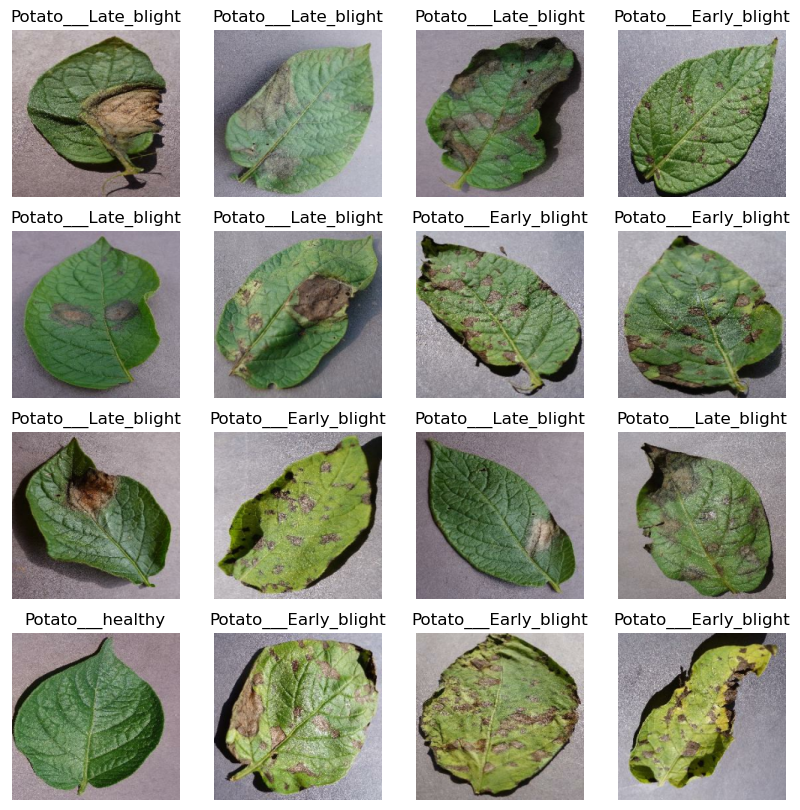

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)
    plt.figure(figsize=(10,10))
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [7]:
def data_partition(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds.shuffle(shuffle_size,seed=23)
    ds_size=len(ds)
    train_size=int(ds_size*train_split)
    #test_size=int(ds_size*test_split)
    val_size=int(ds_size*val_split)
    train_ds=ds.take(train_size)
    test_ds=ds.skip(train_size).skip(val_size)
    val_ds=ds.skip(train_size).take(val_size)
    return train_ds,test_ds,val_ds

In [8]:
train_ds,test_ds,val_ds=data_partition(dataset)
len(train_ds),len(test_ds),len(val_ds)

(54, 8, 6)

In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_rescale=tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(224,224),
        layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE,)+IMG_SIZE+(CHANNELS,)
model=keras.models.Sequential()
model.add(resize_rescale)
model.add(data_augmentation)
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(input_shape),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
model.build(input_shape=input_shape)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                  

In [13]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [14]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1)

Epoch 1/50
54/54 [==============================] - 33s 126ms/step - loss: 0.8261 - accuracy: 0.5880 - val_loss: 0.5033 - val_accuracy: 0.8073
Epoch 2/50
54/54 [==============================] - 2s 45ms/step - loss: 0.4190 - accuracy: 0.8380 - val_loss: 0.3449 - val_accuracy: 0.8698
Epoch 3/50
54/54 [==============================] - 2s 44ms/step - loss: 0.2765 - accuracy: 0.8883 - val_loss: 0.1780 - val_accuracy: 0.9271
Epoch 4/50
54/54 [==============================] - 2s 45ms/step - loss: 0.2413 - accuracy: 0.8987 - val_loss: 0.1279 - val_accuracy: 0.9635
Epoch 5/50
54/54 [==============================] - 2s 44ms/step - loss: 0.1917 - accuracy: 0.9265 - val_loss: 0.1741 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 2s 44ms/step - loss: 0.2664 - accuracy: 0.8941 - val_loss: 0.1727 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 2s 44ms/step - loss: 0.1744 - accuracy: 0.9363 - val_loss: 0.1299 - val_accuracy: 0.9531
Epoch 8/50


In [15]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 56ms/step - loss: 0.0286 - accuracy: 0.9914


[0.02861185558140278, 0.9913793206214905]

Text(0, 0.5, 'loss')

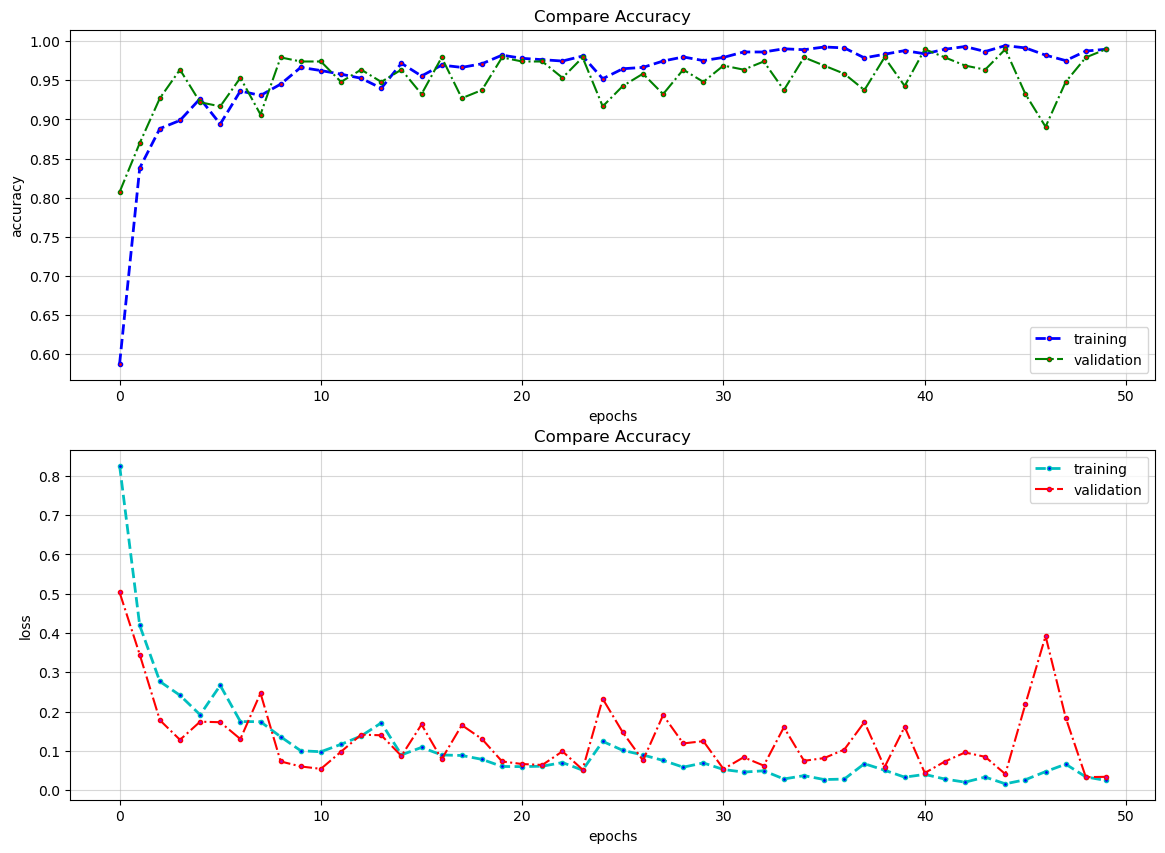

In [16]:
history.history.keys()
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'],color='b',linestyle='--',
         linewidth=2.0,marker='.',markerfacecolor='r')
plt.plot(history.history['val_accuracy'],color='g',linestyle='-.',
         linewidth=1.5,marker='.',markerfacecolor='r')
plt.grid(alpha=0.5)
plt.legend(['training','validation'])
plt.title('Compare Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.subplot(2,1,2)
plt.plot(history.history['loss'],color='c',linestyle='--',
         linewidth=2.0,marker='.',markerfacecolor='b')
plt.plot(history.history['val_loss'],color='r',linestyle='-.',
         linewidth=1.5,marker='.',markerfacecolor='m')
plt.grid(alpha=0.5)
plt.legend(['training','validation'])
plt.title('Compare Accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')

In [17]:
def get_prediction(model,img):
    img_arr=tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_arr=tf.expand_dims(img_arr,0)
    predicted=model.predict(img_arr)
    result=classes[np.argmax(predicted[0])]
    accuracy=np.round(100*np.max(predicted[0]),2)
    return result,accuracy

1/1 [==============================] - 0s 25ms/step


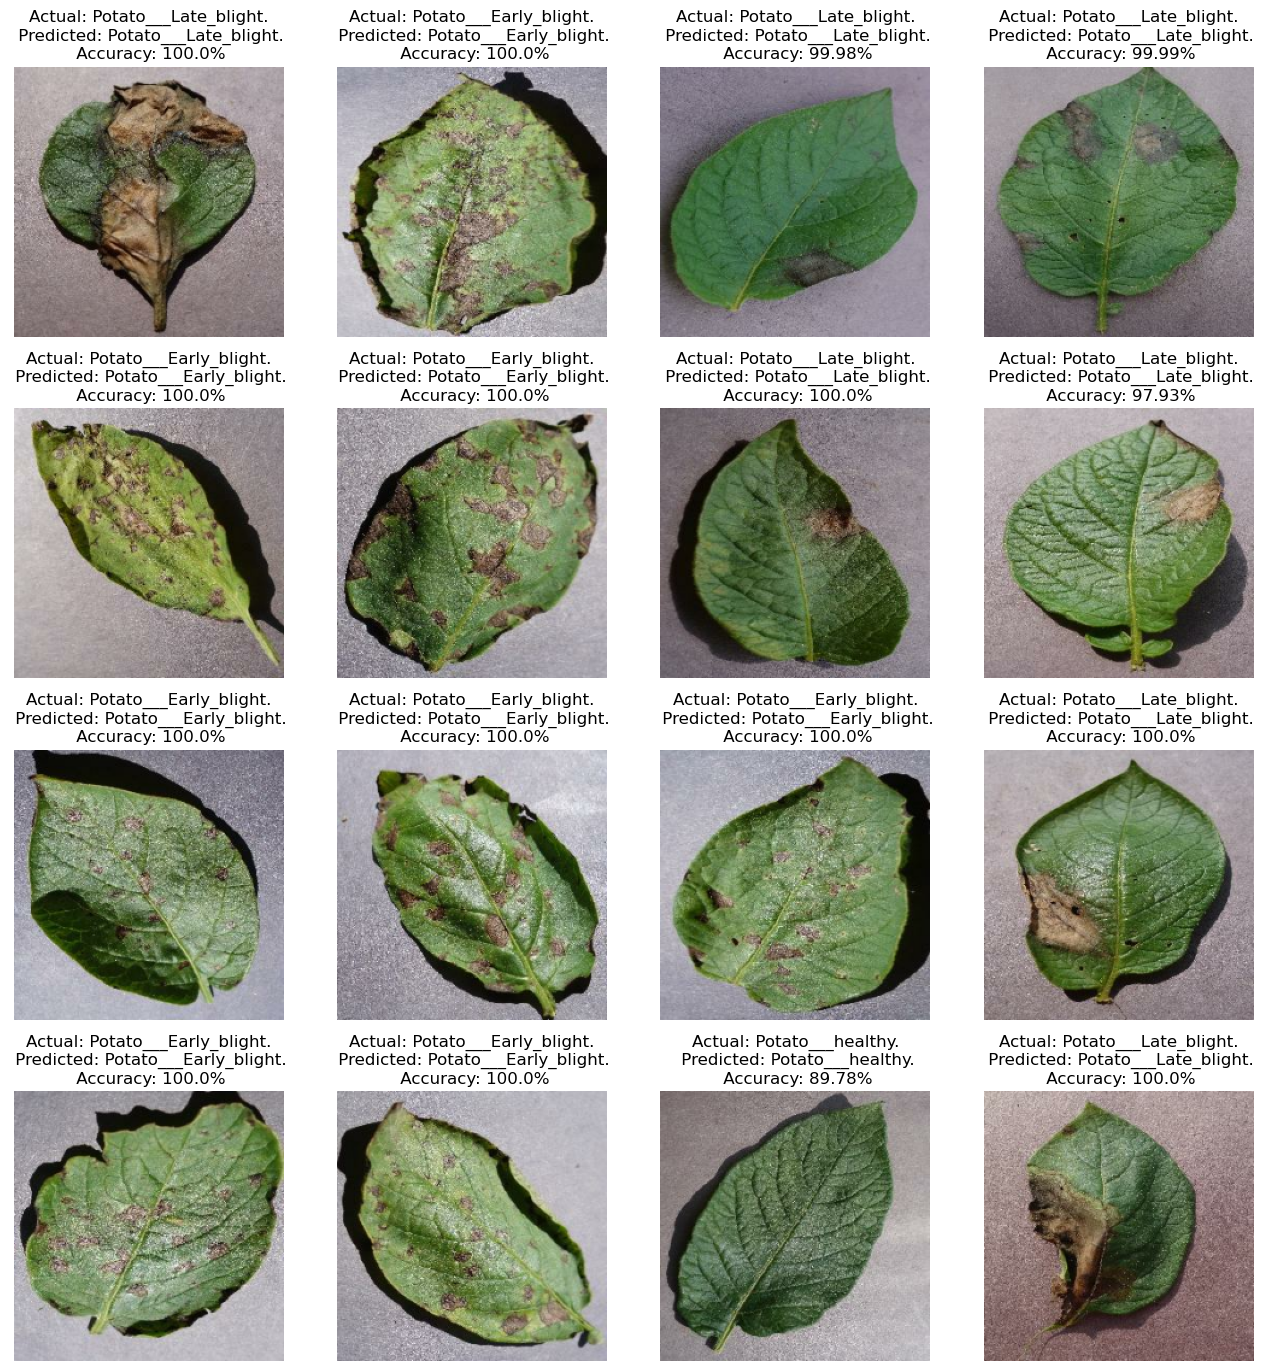

In [18]:
for image_batch,label_batch in dataset.take(1):
    plt.figure(figsize=(16,17))
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        predict,accuracy=get_prediction(model,image_batch[i])
        title=f"Actual: {classes[label_batch[i]]}.\n Predicted: {predict}.\n Accuracy: {accuracy}%" 
        plt.title(title)
        plt.axis('off')

In [19]:
model.save('/kaggle/working/leaf_model.h5')